In [1]:
# !pip install --quiet langchain langchain-openai langchain-community deep-translator

## Sistema Colaborativo (multi-agente) para el Análisis de Datos e Historia
Este notebook implementa un sistema de colaboración de múltiples agentes que combina la investigación histórica con el análisis de datos para responder preguntas históricas complejas. Aprovecha el poder de los modelos de lenguaje grandes para simular que agentes especializados trabajan juntos para brindar respuestas integrales.

### Motivación
El análisis histórico a menudo requiere tanto una comprensión contextual profunda como una interpretación de datos cuantitativos. Al crear un sistema que combina estos dos aspectos, nuestro objetivo es brindar respuestas más sólidas y perspicaces a preguntas históricas complejas. Este enfoque imita la colaboración del mundo real entre historiadores y analistas de datos, lo que potencialmente conduce a perspectivas históricas más matizadas y basadas en datos.

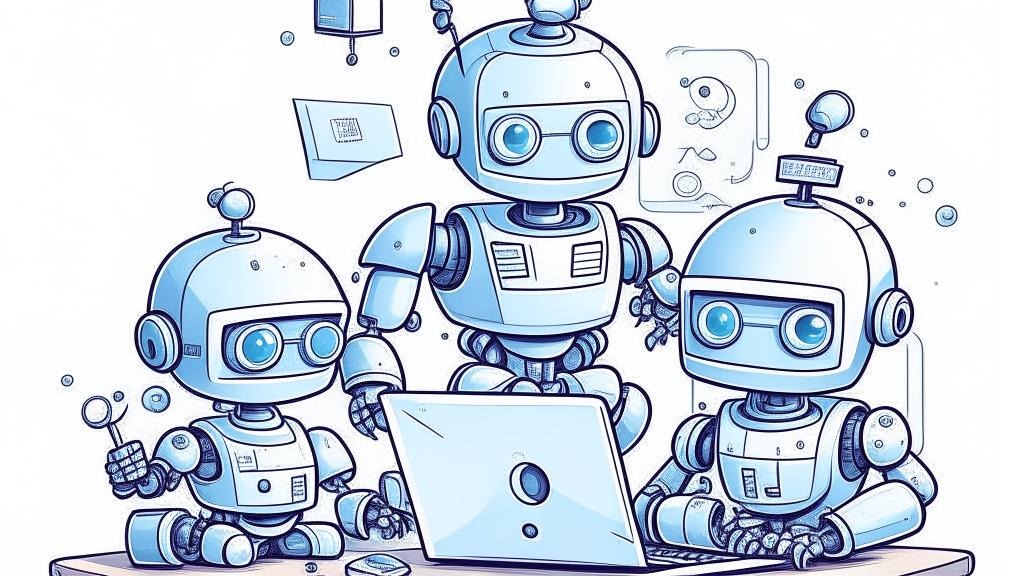

## Componentes clave
1. **Clase de agente**: una clase base para crear agentes de IA especializados.

2. **HistoricalResearchAgent**: especializado en contexto y tendencias históricas.

3. **DataAnalysisAgent**: centrado en la interpretación de datos numéricos y estadísticas.

4. **HistoricalDataCollaborationSystem**: organiza la colaboración entre agentes.

## Detalles del método
El sistema (workflow) sigue estos pasos:

1. **Contexto histórico**: el agente de historia proporciona antecedentes históricos relevantes.

2. **Identificación de las necesidades de datos**: el agente de datos determina qué información cuantitativa se necesita.

3. **Suministro de datos históricos**: el agente de datos históricos proporciona datos históricos relevantes.

4. **Análisis de datos**: el agente de datos interpreta los datos históricos proporcionados.

5. **Síntesis final**: el agente de datos históricos combina todos los conocimientos en una respuesta integral.

Este proceso iterativo permite un intercambio entre el contexto histórico y el análisis de datos, imitando la investigación colaborativa del mundo real.

In [2]:
import os
# from google.colab import userdata
import time
from IPython.display import display, Markdown
from typing import List, Dict
from deep_translator import GoogleTranslator

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.memory import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

### Inicializar el modelo de lenguaje

In [3]:
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

model = ChatOpenAI(model="gpt-4o-mini")

# Test LLM
response = model.invoke("Tell me a joke about data scientists")
print(response.content)

Why do data scientists love nature?

Because they enjoy finding correlations in the wild!


---

### Definir la clase base del Agente

Esta clase *Agent* permite crear un agente que puede procesar tareas basándose en su nombre, rol y habilidades. El método process construye un contexto de conversación, invoca un modelo de lenguaje con ese contexto y devuelve una respuesta adecuada.

In [4]:
class Agent:

    TEMPLATE = """You are {name}, a {role}. Your skills include: {skills}.

    Previous conversation history:
    {chat_history}

    Human: {task}
    Chatbot:"""

    def __init__(self, name: str, role: str, skills: List[str]):
        self.name = name
        self.role = role
        self.skills = skills
        self.model = ChatOpenAI(model="gpt-4o-mini")

    def process(self, task: str, memory: ChatMessageHistory) -> str:

        prompt = PromptTemplate(
            input_variables=["name", "role", "skills", "chat_history", "task"],
            template=self.TEMPLATE
            )

        first_step = {"name": lambda x: self.name,
                      "role": lambda x: self.role,
                      "skills": lambda x: self.skills,
                      "task": RunnablePassthrough(),
                      "chat_history": RunnablePassthrough(),
                      }
        chain = first_step | prompt | self.model
        with_memory= RunnableWithMessageHistory(
            chain,
           # This is needed because in most real world scenarios, a session id is needed
           # It isn't really used here because we are using a simple in memory ChatMessageHistory
            lambda session_id: memory,
            input_messages_key="task",
            history_messages_key="chat_history"
            )
        response = with_memory.invoke(
            {"task": task},
            config={"configurable": {"session_id": "<foo>"}})

        return response.content  # Retorna el contenido de la respuesta


### Definir agentes especializados: HistoryResearchAgent y DataAnalysisAgent

En resumen, las clases *HistoryResearchAgent* y *DataAnalysisAgent* son implementaciones específicas de la clase base Agent.

*HistoryResearchAgent* se configura como un especialista en historia, con habilidades que incluyen un conocimiento profundo de eventos históricos, comprensión de contextos históricos e identificación de tendencias históricas.

*DataAnalysisAgent* se establece como un experto en análisis de datos, con habilidades en interpretación de datos numéricos, análisis estadístico y descripción de visualizaciones de datos.

Ambos agentes están diseñados para realizar tareas específicas en sus respectivos campos, aprovechando la funcionalidad general de la clase Agent para interactuar con modelos de lenguaje y responder a solicitudes relacionadas con su área de especialización.

In [5]:
class HistoryResearchAgent(Agent):
    def __init__(self):
        super().__init__(name="Clio", role="History Research Specialist",
                         skills=["deep knowledge of historical events", "understanding of historical contexts", "identifying historical trends"])

class DataAnalysisAgent(Agent):
    def __init__(self):
        super().__init__(name="Data", role="Data Analysis Expert",
                         skills=["interpreting numerical data", "statistical analysis", "data visualization description"])

#### Research Historical Context

Esta función se encarga de investigar y proporcionar contexto histórico relevante para una tarea específica. Utiliza un agente especializado en historia para procesar la solicitud y devuelve el contexto actualizado.

In [6]:
def research_historical_context(history_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("🏛️ History Agent: Researching historical context...")
    history_task = f"Provide relevant historical context and information for the following task: {task}"

    history_result = history_agent.process(history_task, context)
    context.add_ai_message(f"History Agent: {history_result}")
    print(f"📜 Historical context provided: {history_result[:100]}...\n")

    return context

#### Identify Data Needs

Esta función se encarga de identificar las necesidades específicas de datos o información estadística que pueden ayudar a responder a una pregunta original, basándose en el contexto histórico proporcionado anteriormente. Utiliza un agente especializado en análisis de datos para procesar esta solicitud y devuelve el contexto actualizado.

In [7]:
def identify_data_needs(data_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("📊 Data Agent: Identifying data needs based on historical context...")
    historical_context = context.messages[-1].content
    data_need_task = f"Based on the historical context, what specific data or statistical information would be helpful to answer the original question? Historical context: {historical_context}"

    data_need_result = data_agent.process(data_need_task, context)
    context.add_ai_message(f"Data Agent: {data_need_result}")
    print(f"🔍 Data needs identified: {data_need_result[:100]}...\n")

    return context


#### Provide Historical Data

Esta función se encarga de proporcionar datos históricos relevantes en respuesta a las necesidades de datos identificadas previamente. Utiliza un agente especializado en investigación histórica para procesar esta solicitud y devuelve el contexto actualizado.

In [8]:
def provide_historical_data(history_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("🏛️ History Agent: Providing relevant historical data...")
    data_needs = context.messages[-1].content
    data_provision_task = f"Based on the data needs identified, provide relevant historical data or statistics. Data needs: {data_needs}"

    data_provision_result = history_agent.process(data_provision_task, context)
    context.add_ai_message(f"History Agent: {data_provision_result}")
    print(f"📊 Historical data provided: {data_provision_result[:100]}...\n")

    return context

#### Analyze Data

Esta función se encarga de analizar datos históricos relevantes y extraer tendencias o información importante que puede ayudar a abordar la tarea original. Utiliza un agente especializado en análisis de datos para realizar este análisis y devuelve el contexto actualizado con los resultados.

In [9]:
def analyze_data(data_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("📈 Data Agent: Analyzing historical data...")
    historical_data = context.messages[-1].content
    analysis_task = f"Analyze the historical data provided and describe any trends or insights relevant to the original task. Historical data: {historical_data}"

    analysis_result = data_agent.process(analysis_task, context)
    context.add_ai_message(f"Data Agent: {analysis_result}")
    print(f"💡 Data analysis results: {analysis_result[:100]}...\n")

    return context

#### Synthesize Final Answer

Esta función se encarga de integrar toda la información recopilada a lo largo del proceso (incluyendo contexto histórico, datos y análisis) y proporcionar una respuesta final completa y coherente a la tarea original. Utiliza un agente especializado en investigación histórica para llevar a cabo esta síntesis y devolver el resultado.

In [10]:
def synthesize_final_answer(history_agent, task: str, context: ChatMessageHistory) -> str:
    print("🏛️ History Agent: Synthesizing final answer...")
    synthesis_task = "Based on all the historical context, data, and analysis, provide a comprehensive answer to the original task."

    final_result = history_agent.process(synthesis_task, context)
    context.add_ai_message(final_result)

    return context

### HistoryDataCollaborationSystem: El Sistema Multiagente

La clase *HistoryDataCollaborationSystem* gestiona la colaboración entre dos agentes especializados (uno en historia y otro en análisis de datos) para resolver tareas complejas que requieren información histórica y análisis de datos. A través del método solve, la clase coordina una serie de pasos definidos, asegurando que se cumplan los tiempos de ejecución y manejando posibles errores, hasta llegar a una respuesta final que integra toda la información recopilada.

In [11]:
class HistoryDataCollaborationSystem:
    def __init__(self):
      self.history_agent = HistoryResearchAgent()
      self.data_agent = DataAnalysisAgent()

    def solve(self, task: str, timeout: int = 300) -> str:
        print(f"\n👥 Starting collaboration to solve: {task}\n")

        start_time = time.time()
        memory = ChatMessageHistory(session_id="test-session") # []

        steps = [ # This is the main execution workflow
            (research_historical_context, self.history_agent),
            (identify_data_needs, self.data_agent),
            (provide_historical_data, self.history_agent),
            (analyze_data, self.data_agent),
            (synthesize_final_answer, self.history_agent)
        ]

        for step_func, agent in steps:
            if time.time() - start_time > timeout:
                return "Operation timed out. The process took too long to complete."
            try:
                result = step_func(agent, task, memory)
                memory = result
            except Exception as e:
                return f"Error during collaboration: {str(e)}"

        print("\n✅ Collaboration complete. Final answer synthesized.\n")
        return memory.messages[-1].content # if memory else "No content available."


## **Ejemplo de uso**

Este código crea un sistema que integra agentes de historia y análisis de datos para abordar preguntas complejas que requieren una comprensión profunda de contextos históricos y el análisis de datos relevantes. Al final, el resultado se presenta de manera que responde a la pregunta formulada.

In [12]:
# Create an instance of the collaboration system
collaboration_system = HistoryDataCollaborationSystem()

# Define a complex historical question that requires both historical knowledge and data analysis
question = "How did urbanization rates in Europe compare to those in North America during the Industrial Revolution, and what were the main factors influencing these trends?"
# question = "¿Como fue la evolucion del COVID-19?"

# Solve the question using the collaboration system
result = collaboration_system.solve(question)

# Print the result
print()
# print(result)
display(Markdown(result))


👥 Starting collaboration to solve: How did urbanization rates in Europe compare to those in North America during the Industrial Revolution, and what were the main factors influencing these trends?

🏛️ History Agent: Researching historical context...
📜 Historical context provided: During the Industrial Revolution, which roughly spanned from the late 18th to the early 19th centuri...

📊 Data Agent: Identifying data needs based on historical context...
🔍 Data needs identified: To effectively analyze urbanization rates in Europe and North America during the Industrial Revoluti...

🏛️ History Agent: Providing relevant historical data...
📊 Historical data provided: To provide a detailed overview of urbanization rates in Europe and North America during the Industri...

📈 Data Agent: Analyzing historical data...
💡 Data analysis results: During the Industrial Revolution, Europe and North America witnessed distinct patterns of urbanizati...

🏛️ History Agent: Synthesizing final answer...

✅ Col

During the Industrial Revolution, which spanned from the late 18th century to about the mid-19th century, Europe and North America underwent significant urbanization at different rates, driven by various contextual factors. Below is a comprehensive analysis based on historical data and insights:

### Urbanization Rates

1. **Europe:**
   - **Timing of Urbanization:** The Industrial Revolution initiated in Great Britain during the late 18th century. By 1850, major urban centers such as Manchester had urban populations exceeding 70%, while cities like London had around 50% of their populations living in urban areas.
   - **Spread Across Continent:** Other European nations such as France and Germany saw slower initial urbanization; however, it accelerated as infrastructure improved and industries expanded throughout the 19th century.

2. **North America:**
   - **Gradual Urbanization:** Urbanization in the United States primarily accelerated after 1860, where the urban population was around 19%. By 1900, this increased to approximately 40%, highlighting a significant urban growth, especially in cities like New York and Chicago.
   - **Late Comers:** Compared to Europe, urban growth in North America occurred later in the 19th century, reflecting the combined effects of industrialization, immigration, and railroad expansion.

### Key Factors Influencing Urbanization Trends

1. **Economic Factors:**
   - **Europe:** The rise of factories and mechanized production drew massive labor from rural areas. This transition was also influenced by agricultural changes that displaced many rural workers.
   - **North America:** Factors such as the transcontinental railroad and land availability facilitated movement to urban areas and contributed to job creation.

2. **Social Factors:**
   - **European Context:** With a longer history of urban culture, cities served as vital cultural and political centers, but overcrowding and poor living conditions led to social reform movements advocating for public health improvements.
   - **North American Trends:** Urban growth was heavily influenced by immigration waves, with millions arriving in search of opportunities during the late 19th and early 20th centuries, which rapidly changed urban demographics.

3. **Technological Innovations:**
   - In Europe, advancements like steam power enhanced factory production, leading to increased migration to industrial cities.
   - In North America, innovations such as the telegraph and various mechanized tools bolstered industrial growth and attracted further migration.

4. **Government Policies:**
   - European governments began to address urban challenges through planning and labor regulations, while the laissez-faire policies of the U.S. often resulted in unchecked urban expansion, leading to significant social challenges.

### Conclusion

In summary, the urbanization experienced in Europe during the Industrial Revolution was more pronounced and earlier compared to North America. Europe's early industrial practices and established urban culture propelled rapid urbanization, while North America's urban growth was characterized by substantial immigration and infrastructural development that gained momentum later in the 19th century. Clarifying these differences provides valuable insights into the historical contexts that shaped each region's urban landscape during this transformative period. Understanding these patterns of urbanization also sheds light on the socio-economic challenges and changes that occurred as societies transitioned from rural to urban living.

## **Discusion**

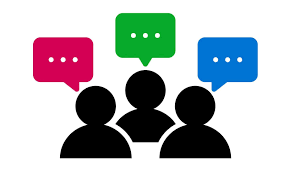

---

## **Extra: ¿Cómo puedo hacer para que el sistema conteste en Español?**

## **Extra: ¿Y podría agregarle un agente de reflexion/crítica sobre lo generado?**

In [13]:
# TODO: Add your code here

In [14]:
translated = GoogleTranslator(source='auto', target='es').translate(text=result)
translated

'Durante la Revolución Industrial, que se extendió desde finales del siglo XVIII hasta mediados del siglo XIX, Europa y América del Norte experimentaron una urbanización significativa a diferentes ritmos, impulsada por diversos factores contextuales. A continuación se muestra un análisis exhaustivo basado en datos y conocimientos históricos:\n\n### Tarifas de urbanización\n\n1. **Europa:**\n   - **Momento de la Urbanización:** La Revolución Industrial se inició en Gran Bretaña a finales del siglo XVIII. En 1850, los principales centros urbanos como Manchester tenían poblaciones urbanas superiores al 70%, mientras que ciudades como Londres tenían alrededor del 50% de su población viviendo en áreas urbanas.\n   - **Difusión por el continente:** Otras naciones europeas como Francia y Alemania experimentaron una urbanización inicial más lenta; sin embargo, se aceleró a medida que la infraestructura mejoró y las industrias se expandieron a lo largo del siglo XIX.\n\n2. **América del Norte:*

In [15]:
display(Markdown(translated))

Durante la Revolución Industrial, que se extendió desde finales del siglo XVIII hasta mediados del siglo XIX, Europa y América del Norte experimentaron una urbanización significativa a diferentes ritmos, impulsada por diversos factores contextuales. A continuación se muestra un análisis exhaustivo basado en datos y conocimientos históricos:

### Tarifas de urbanización

1. **Europa:**
   - **Momento de la Urbanización:** La Revolución Industrial se inició en Gran Bretaña a finales del siglo XVIII. En 1850, los principales centros urbanos como Manchester tenían poblaciones urbanas superiores al 70%, mientras que ciudades como Londres tenían alrededor del 50% de su población viviendo en áreas urbanas.
   - **Difusión por el continente:** Otras naciones europeas como Francia y Alemania experimentaron una urbanización inicial más lenta; sin embargo, se aceleró a medida que la infraestructura mejoró y las industrias se expandieron a lo largo del siglo XIX.

2. **América del Norte:**
   - **Urbanización gradual:** La urbanización en los Estados Unidos se aceleró principalmente después de 1860, cuando la población urbana rondaba el 19%. Para 1900, esto aumentó a aproximadamente el 40%, destacando un crecimiento urbano significativo, especialmente en ciudades como Nueva York y Chicago.
   - **Llegados tardíos:** En comparación con Europa, el crecimiento urbano en América del Norte se produjo más tarde en el siglo XIX, lo que refleja los efectos combinados de la industrialización, la inmigración y la expansión ferroviaria.

### Factores clave que influyen en las tendencias de urbanización

1. **Factores económicos:**
   - **Europa:** El auge de las fábricas y la producción mecanizada atrajo una gran cantidad de mano de obra de las zonas rurales. Esta transición también estuvo influenciada por cambios agrícolas que desplazaron a muchos trabajadores rurales.
   - **América del Norte:** Factores como el ferrocarril transcontinental y la disponibilidad de tierras facilitaron el movimiento hacia áreas urbanas y contribuyeron a la creación de empleo.

2. **Factores sociales:**
   - **Contexto europeo:** Con una historia más larga de cultura urbana, las ciudades sirvieron como centros culturales y políticos vitales, pero el hacinamiento y las malas condiciones de vida llevaron a movimientos de reforma social que abogaban por mejoras en la salud pública.
   - **Tendencias de América del Norte:** El crecimiento urbano estuvo fuertemente influenciado por las olas de inmigración, con millones de personas que llegaron en busca de oportunidades a finales del siglo XIX y principios del XX, lo que cambió rápidamente la demografía urbana.

3. **Innovaciones tecnológicas:**
   - En Europa, avances como la energía de vapor mejoraron la producción fabril, lo que provocó una mayor migración a las ciudades industriales.
   - En América del Norte, innovaciones como el telégrafo y diversas herramientas mecanizadas impulsaron el crecimiento industrial y atrajeron una mayor migración.

4. **Políticas gubernamentales:**
   - Los gobiernos europeos comenzaron a abordar los desafíos urbanos a través de la planificación y las regulaciones laborales, mientras que las políticas de laissez-faire de los Estados Unidos a menudo resultaron en una expansión urbana desenfrenada, lo que generó importantes desafíos sociales.

### Conclusión

En resumen, la urbanización experimentada en Europa durante la Revolución Industrial fue más pronunciada y anterior en comparación con América del Norte. Las primeras prácticas industriales de Europa y la cultura urbana establecida impulsaron una rápida urbanización, mientras que el crecimiento urbano de América del Norte se caracterizó por una inmigración sustancial y un desarrollo infraestructural que cobró impulso a finales del siglo XIX. Aclarar estas diferencias proporciona información valiosa sobre los contextos históricos que dieron forma al paisaje urbano de cada región durante este período transformador. Comprender estos patrones de urbanización también arroja luz sobre los desafíos y cambios socioeconómicos que se produjeron cuando las sociedades pasaron de la vida rural a la urbana.